#

## Se descomprime el Dataset

In [1]:
!rm -r mnist
!unzip mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/train/5/2606.png  

## Se guardan las imagenes que se usaran en el training, valid y test sets en arreglos

In [2]:
from glob import glob
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

## Se organizan los arreglos anteriores de manera aleatoria

In [3]:
import numpy as np
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

## Cargando datos del train, test y valid sets

In [4]:
from PIL import Image   # lee imagenes como arrays

# se cargan los datos del train set
N_train = len(train_files)
X_train, Y_train = [], []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

# se cargan los datos del valid set
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )
  
# se cargan los datos del test set
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )  

len(X_train), len(X_valid), len(X_test)  

(6000, 2000, 992)

## Grafico para ver si estan balanceados o no

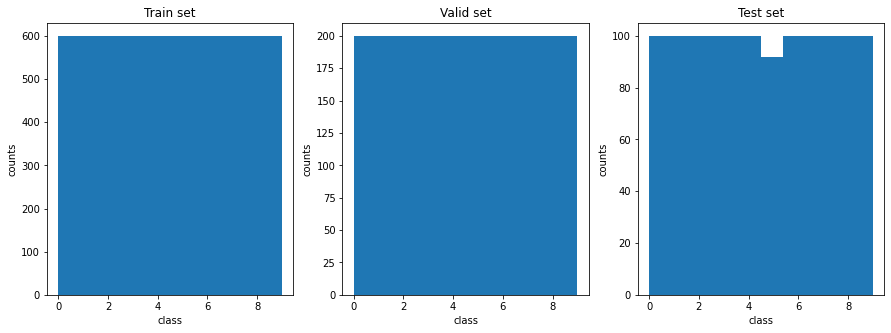

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

## Graficando algunos datos

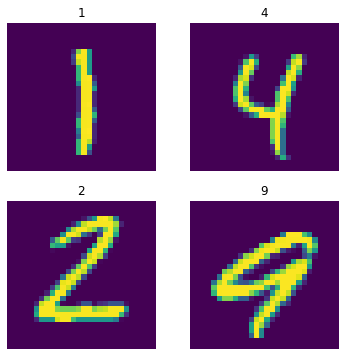

In [6]:
fig = plt.figure(figsize=(6,6))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*3])
  plt.title(Y_test[i*3])
  plt.axis(False)
plt.show()

# ANN




## Creo una funcion que convierte los arrays a tensores para pasarlas a mi modelo de ANN

In [7]:
import torch
from torch.autograd import Variable

def arrays_a_tensores(X_train, Y_train):
  global X_valid, Y_valid, X_test, Y_test
  X_train = Variable(torch.from_numpy(np.array(X_train))).float()
  Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

  X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
  Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

  X_test = Variable(torch.from_numpy(np.array(X_test))).float()
  Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

  X_train.data.size()

  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

##  ANN con dos capas lineales ocultas de 50 neuronas

In [8]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

## Funcion de avance, graficas loss, f1_score y accuracy, y evaluacion del modelo 

In [9]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

def avance_y_grafica(X_train, Y_train):
  n_epoch = 100
  loss_train, f1_train, acc_train = [], [], []
  loss_valid, f1_valid, acc_valid = [], [], []

  # Entrenamiento de la ANN
  for epoch in range(n_epoch):

    #  para datos de entrenamiento
    model.train()     # entreno mi modelo
    
    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    print(len(Y_pred))
    loss = criteria(Y_pred, Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    # los 3 pasos
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

    # para datos de evaluacion
    model.eval()

    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  

    loss = criteria(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()

  plt.savefig('./curves_ok.png', bbox_inches='tight')
  plt.show()


  # evaluacion del modelo
  model.eval()

  Xts = X_test.view(X_test.size(0), -1)
  Y_pred = model(Xts)  
  loss = criteria(Y_pred,Y_test)

  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_test, Y_pred, average='macro')

  acc = sum(Y_test == Y_pred)/len(Y_pred)

  print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

## ANN con 10% de datos de train

In [10]:
len(X_train), len(Y_train)

(6000, 6000)

#### Creo arreglos para guardar valores de 10%

In [11]:
X_train_10 = X_train[0:int(len(X_train)*0.10)]  
len(X_train_10)

600

In [12]:
Y_train_10 = Y_train[0:int(len(Y_train)*0.10)] 
len(Y_train_10)

600

## Convierto a tensores

In [13]:
X_train_10 ,Y_train_10, X_valid, Y_valid, X_test, Y_test = arrays_a_tensores(X_train_10, Y_train_10)  

## Grafico loss, f1_score y accuracy para los training y valid sets


600
Epoch [1/100], loss: 12.223485946655273. f1:0.08130037593823759 acc: 0.14499999582767487 
600
Epoch [2/100], loss: 6.305209159851074. f1:0.16376339126458855 acc: 0.1899999976158142 
600
Epoch [3/100], loss: 4.71726131439209. f1:0.23260821113493604 acc: 0.2666666805744171 
600
Epoch [4/100], loss: 3.6885313987731934. f1:0.2761332292074988 acc: 0.3283333480358124 
600
Epoch [5/100], loss: 3.0362138748168945. f1:0.3060053125480495 acc: 0.36666667461395264 
600
Epoch [6/100], loss: 2.5443153381347656. f1:0.35283314744652694 acc: 0.41333332657814026 
600
Epoch [7/100], loss: 2.1324303150177. f1:0.41173909684488735 acc: 0.4633333384990692 
600
Epoch [8/100], loss: 1.7393571138381958. f1:0.47561513032638175 acc: 0.5149999856948853 
600
Epoch [9/100], loss: 1.4776712656021118. f1:0.5214712196812449 acc: 0.54666668176651 
600
Epoch [10/100], loss: 1.2836799621582031. f1:0.5699930241701008 acc: 0.5933333039283752 
600
Epoch [11/100], loss: 1.086121678352356. f1:0.6406828329690393 acc: 0.6633

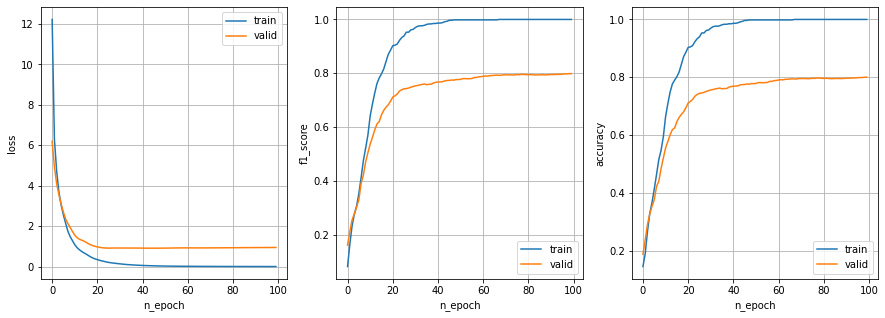

loss: 0.8462337851524353, f1: 0.8217286543506891, acc: 0.8235887289047241


In [14]:
avance_y_grafica(X_train_10, Y_train_10)

## ANN con 20 % de datos 

In [15]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

In [16]:
X_train_20 = X_train[0:int(len(X_train)*0.20)]  #(Entrenando con 20% del tamaño del X_train set)
Y_train_20 = Y_train[0:int(len(Y_train)*0.20)] 

In [17]:
X_train_20 ,Y_train_20, X_valid, Y_valid, X_test, Y_test = arrays_a_tensores(X_train_20, Y_train_20) 

1200
Epoch [1/100], loss: 12.104454040527344. f1:0.07059906156842703 acc: 0.12833333015441895 
1200
Epoch [2/100], loss: 7.125287055969238. f1:0.1253297977031829 acc: 0.1783333271741867 
1200
Epoch [3/100], loss: 4.425022125244141. f1:0.18066030482120007 acc: 0.2358333319425583 
1200
Epoch [4/100], loss: 3.345371961593628. f1:0.2404860228526716 acc: 0.2549999952316284 
1200
Epoch [5/100], loss: 3.051685094833374. f1:0.2701952023745203 acc: 0.2683333456516266 
1200
Epoch [6/100], loss: 2.558425188064575. f1:0.3402101136490593 acc: 0.335833340883255 
1200
Epoch [7/100], loss: 1.9755058288574219. f1:0.4433588976772292 acc: 0.43166667222976685 
1200
Epoch [8/100], loss: 1.575941801071167. f1:0.5215030466791549 acc: 0.51583331823349 
1200
Epoch [9/100], loss: 1.3614572286605835. f1:0.5793210600015299 acc: 0.5866666436195374 
1200
Epoch [10/100], loss: 1.2228713035583496. f1:0.6072225419848731 acc: 0.6258333325386047 
1200
Epoch [11/100], loss: 1.1162292957305908. f1:0.6439425238665402 acc: 

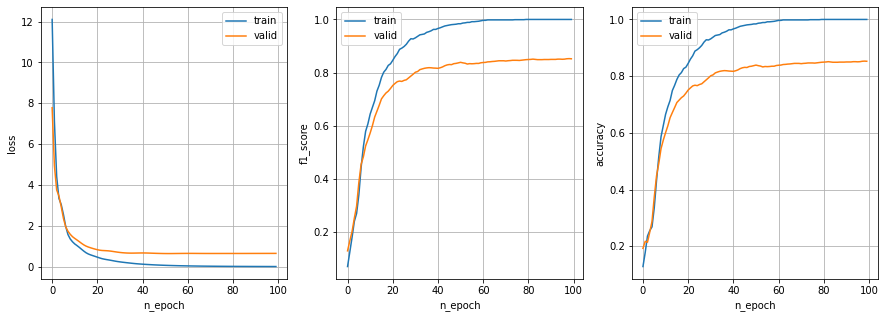

loss: 0.5601734519004822, f1: 0.872695597717505, acc: 0.8729838728904724


In [18]:
avance_y_grafica(X_train_20, Y_train_20)

## ANN con 50 % de datos

In [19]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

3000
Epoch [1/100], loss: 8.893689155578613. f1:0.069307340630678 acc: 0.11933333426713943 
3000
Epoch [2/100], loss: 6.2202019691467285. f1:0.0917515242437197 acc: 0.11699999868869781 
3000
Epoch [3/100], loss: 4.264216423034668. f1:0.1715584474712018 acc: 0.20399999618530273 
3000
Epoch [4/100], loss: 2.9767098426818848. f1:0.2765529317714065 acc: 0.30566665530204773 
3000
Epoch [5/100], loss: 2.4905474185943604. f1:0.33593589839729254 acc: 0.36800000071525574 
3000
Epoch [6/100], loss: 2.102174758911133. f1:0.4005829453803059 acc: 0.42533332109451294 
3000
Epoch [7/100], loss: 1.711270809173584. f1:0.4741109389442788 acc: 0.4933333396911621 
3000
Epoch [8/100], loss: 1.4794752597808838. f1:0.5278907166632736 acc: 0.5446666479110718 
3000
Epoch [9/100], loss: 1.3594242334365845. f1:0.5651415533823292 acc: 0.5830000042915344 
3000
Epoch [10/100], loss: 1.2632540464401245. f1:0.601998347298536 acc: 0.6183333396911621 
3000
Epoch [11/100], loss: 1.1617639064788818. f1:0.644695009973164 

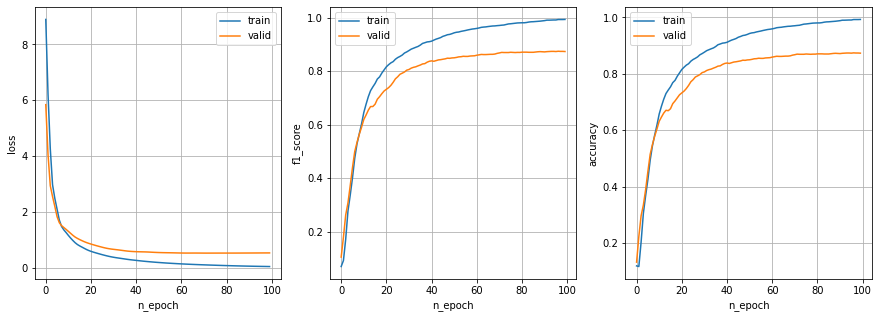

loss: 0.492112934589386, f1: 0.8981464143342043, acc: 0.8981854915618896


In [20]:
X_train_50 = X_train[0:int(len(X_train)*0.50)]  #(Entrenando con 20% del tamaño del X_train set)
Y_train_50 = Y_train[0:int(len(Y_train)*0.50)] 

X_train_50 ,Y_train_50, X_valid, Y_valid, X_test, Y_test = arrays_a_tensores(X_train_50, Y_train_50)

avance_y_grafica(X_train_50, Y_train_50)

## ANN con 50 % de datos

In [21]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

3000
Epoch [1/100], loss: 12.182716369628906. f1:0.032693623189419416 acc: 0.059333331882953644 
3000
Epoch [2/100], loss: 6.2279863357543945. f1:0.11240743760790295 acc: 0.13500000536441803 
3000
Epoch [3/100], loss: 4.699038505554199. f1:0.1787544312396733 acc: 0.20466665923595428 
3000
Epoch [4/100], loss: 3.4987659454345703. f1:0.2680004610411289 acc: 0.2903333306312561 
3000
Epoch [5/100], loss: 2.577124834060669. f1:0.3900659542831207 acc: 0.414000004529953 
3000
Epoch [6/100], loss: 1.984529972076416. f1:0.4654552670438529 acc: 0.49166667461395264 
3000
Epoch [7/100], loss: 1.6893565654754639. f1:0.4898742615276476 acc: 0.5146666765213013 
3000
Epoch [8/100], loss: 1.5747261047363281. f1:0.5166025859326194 acc: 0.5306666493415833 
3000
Epoch [9/100], loss: 1.4795678853988647. f1:0.5420674923238066 acc: 0.5519999861717224 
3000
Epoch [10/100], loss: 1.3395661115646362. f1:0.5844354988788583 acc: 0.5883333086967468 
3000
Epoch [11/100], loss: 1.181818962097168. f1:0.63354979133587

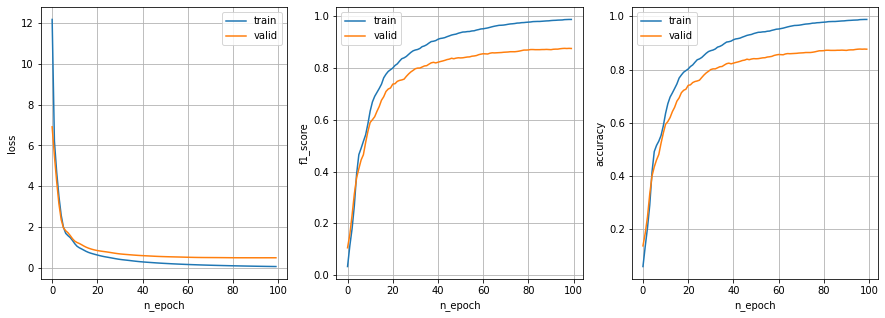

loss: 0.4851341247558594, f1: 0.8693489365215529, acc: 0.8699596524238586


In [22]:
X_train_50 = X_train[0:int(len(X_train)*0.50)]  #(Entrenando con 20% del tamaño del X_train set)
Y_train_50 = Y_train[0:int(len(Y_train)*0.50)] 

X_train_50 ,Y_train_50, X_valid, Y_valid, X_test, Y_test = arrays_a_tensores(X_train_50, Y_train_50)

avance_y_grafica(X_train_50, Y_train_50)

# ANN con 100% de datos de training set

In [23]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

6000
Epoch [1/100], loss: 10.994546890258789. f1:0.06322236174381281 acc: 0.10616666823625565 
6000
Epoch [2/100], loss: 7.106543064117432. f1:0.12210197727702563 acc: 0.1626666635274887 
6000
Epoch [3/100], loss: 4.64375114440918. f1:0.20333236280395375 acc: 0.2448333352804184 
6000
Epoch [4/100], loss: 3.5101747512817383. f1:0.28493519569725334 acc: 0.32766667008399963 
6000
Epoch [5/100], loss: 2.8488359451293945. f1:0.3318263878535518 acc: 0.3720000088214874 
6000
Epoch [6/100], loss: 2.5371336936950684. f1:0.3865991692713455 acc: 0.41850000619888306 
6000
Epoch [7/100], loss: 2.1317138671875. f1:0.452522904718755 acc: 0.4814999997615814 
6000
Epoch [8/100], loss: 1.7592167854309082. f1:0.5152918487366097 acc: 0.5410000085830688 
6000
Epoch [9/100], loss: 1.5244057178497314. f1:0.5709194136013834 acc: 0.5838333368301392 
6000
Epoch [10/100], loss: 1.41069757938385. f1:0.5992108176615762 acc: 0.6054999828338623 
6000
Epoch [11/100], loss: 1.324495553970337. f1:0.6151865880406298 acc

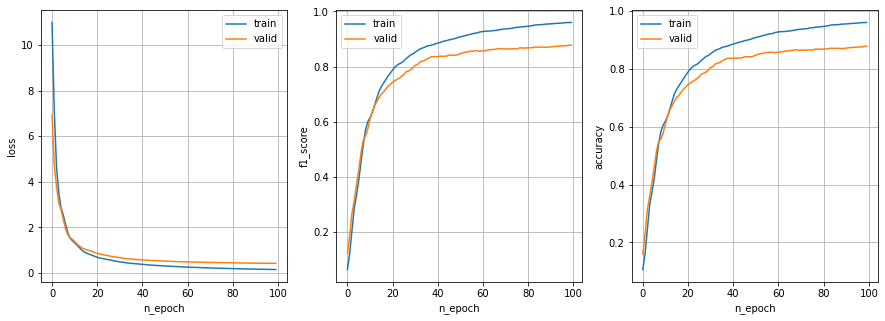

loss: 0.42407649755477905, f1: 0.8867059984080032, acc: 0.8870967626571655


In [24]:
 X_train,Y_train, X_valid, Y_valid, X_test, Y_test = arrays_a_tensores(X_train, Y_train)

avance_y_grafica(X_train, Y_train)

# Analisis

i) La importancia del conjunto de entrenamiento es que se necesita de suficientes datos para que el modelo a usar aprenda de mejor manera.

ii y iii) Como se ve en las gráficas de scores vs numero de epoca, el valor de pérdida disminuye a mayor número de época, y si se incluyen más datos, el loss final será menor, como se ve en el valor de loss impreso. Por otro lado, con el score f1_score se puede ver que la curva del valid set se acerca más a la de train set a mayor número de datos, lo que indica que el f1 score va aumentando, de la misma manera que las gráficas de accuracy.


## Ahora cambiando tamaño de conjunto test

In [25]:
# Redefino mi funcion:

def arrays_a_tensores(X_test, Y_test):
  global X_valid, Y_valid, X_train, Y_train
  X_train = Variable(torch.from_numpy(np.array(X_train))).float()
  Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

  X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
  Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

  X_test = Variable(torch.from_numpy(np.array(X_test))).float()
  Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

  X_train.data.size()

  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

## 10% de tamaño de test set

In [26]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

99
Epoch [1/100], loss: 20.772737503051758. f1:0.06356161232821574 acc: 0.10101009905338287 
99
Epoch [2/100], loss: 9.545004844665527. f1:0.13708498816857953 acc: 0.20202019810676575 
99
Epoch [3/100], loss: 4.8302178382873535. f1:0.16485498997126904 acc: 0.2525252401828766 
99
Epoch [4/100], loss: 3.1830170154571533. f1:0.23932873791365067 acc: 0.2929292917251587 
99
Epoch [5/100], loss: 2.2001309394836426. f1:0.3668302144211558 acc: 0.4141414165496826 
99
Epoch [6/100], loss: 1.6739866733551025. f1:0.4607638188672672 acc: 0.5353535413742065 
99
Epoch [7/100], loss: 1.348899245262146. f1:0.5670458128475205 acc: 0.6464646458625793 
99
Epoch [8/100], loss: 1.0673604011535645. f1:0.5772469060007759 acc: 0.6565656661987305 
99
Epoch [9/100], loss: 0.9021053910255432. f1:0.5851535894150495 acc: 0.6565656661987305 
99
Epoch [10/100], loss: 0.7536916136741638. f1:0.689199386999867 acc: 0.7272727489471436 
99
Epoch [11/100], loss: 0.5825546979904175. f1:0.7552075702075702 acc: 0.787878811359

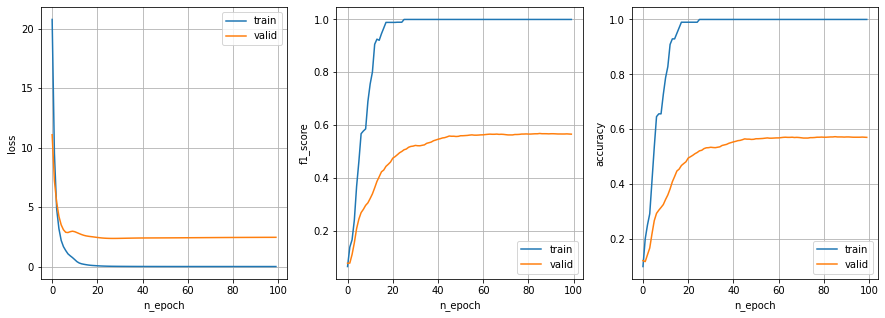

loss: 1.6253749132156372, f1: 0.6876420732685358, acc: 0.6925403475761414


In [27]:
X_test_10 = X_test[0:int(len(X_test)*0.10)] 
Y_test_10 = Y_test[0:int(len(Y_test)*0.10)] 

X_train ,Y_train, X_valid, Y_valid, X_test_10, Y_test_10 = arrays_a_tensores(X_test_10, Y_test_10)

avance_y_grafica(X_test_10, Y_test_10)

# 20% de tamaño de test set

In [28]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

198
Epoch [1/100], loss: 13.563959121704102. f1:0.06900886408458465 acc: 0.11616161465644836 
198
Epoch [2/100], loss: 7.383121967315674. f1:0.11192585192585192 acc: 0.14141413569450378 
198
Epoch [3/100], loss: 5.055236339569092. f1:0.17459730369393484 acc: 0.21212121844291687 
198
Epoch [4/100], loss: 3.842970132827759. f1:0.21631482527134702 acc: 0.2626262605190277 
198
Epoch [5/100], loss: 2.71396541595459. f1:0.3598603099650885 acc: 0.39898988604545593 
198
Epoch [6/100], loss: 2.0060415267944336. f1:0.4805771896412291 acc: 0.5101010203361511 
198
Epoch [7/100], loss: 1.5942209959030151. f1:0.568024198024198 acc: 0.5808081030845642 
198
Epoch [8/100], loss: 1.3233323097229004. f1:0.6157771000411283 acc: 0.6212121248245239 
198
Epoch [9/100], loss: 1.136610507965088. f1:0.6791419615786718 acc: 0.6767676472663879 
198
Epoch [10/100], loss: 0.9756620526313782. f1:0.7163492269377678 acc: 0.7171717286109924 
198
Epoch [11/100], loss: 0.8590921759605408. f1:0.7320154658364753 acc: 0.732

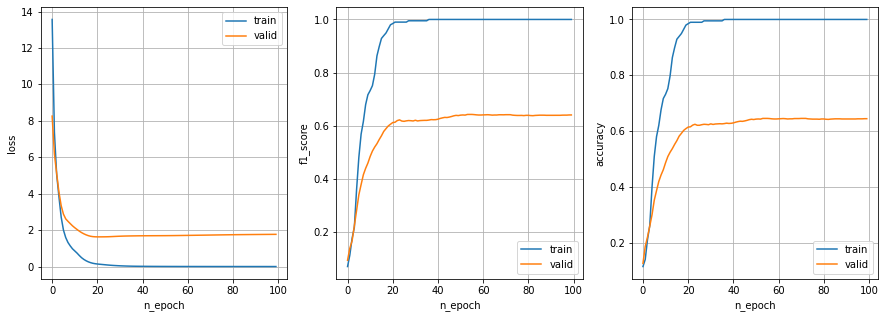

loss: 0.9282188415527344, f1: 0.805886672134055, acc: 0.8074596524238586


In [29]:
X_test_20 = X_test[0:int(len(X_test)*0.20)] 
Y_test_20 = Y_test[0:int(len(Y_test)*0.20)] 

X_train ,Y_train, X_valid, Y_valid, X_test_20, Y_test_20 = arrays_a_tensores(X_test_20, Y_test_20)

avance_y_grafica(X_test_20, Y_test_20)

# 50% de tamaño de test set

In [30]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

496
Epoch [1/100], loss: 8.70517349243164. f1:0.05860611542775157 acc: 0.08467742055654526 
496
Epoch [2/100], loss: 5.186956882476807. f1:0.12445965933334038 acc: 0.15322580933570862 
496
Epoch [3/100], loss: 3.523916006088257. f1:0.21844961795346637 acc: 0.22782258689403534 
496
Epoch [4/100], loss: 2.877687931060791. f1:0.29796619073577835 acc: 0.3145161271095276 
496
Epoch [5/100], loss: 2.334731340408325. f1:0.39110539642256525 acc: 0.41330644488334656 
496
Epoch [6/100], loss: 1.7710696458816528. f1:0.5106962307272251 acc: 0.5282257795333862 
496
Epoch [7/100], loss: 1.389323115348816. f1:0.5900307786368908 acc: 0.6129032373428345 
496
Epoch [8/100], loss: 1.1265615224838257. f1:0.660487282473026 acc: 0.6814516186714172 
496
Epoch [9/100], loss: 0.913736879825592. f1:0.7159949324498912 acc: 0.7358871102333069 
496
Epoch [10/100], loss: 0.763739287853241. f1:0.7364123191204068 acc: 0.7520161271095276 
496
Epoch [11/100], loss: 0.6706542372703552. f1:0.7655341022212441 acc: 0.77620

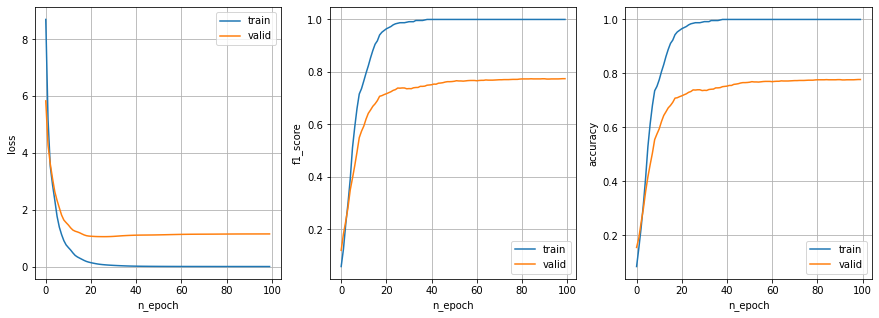

loss: 0.26576513051986694, f1: 0.9433644719561993, acc: 0.9435483813285828


In [31]:
X_test_50 = X_test[0:int(len(X_test)*0.50)] 
Y_test_50 = Y_test[0:int(len(Y_test)*0.50)] 

X_train ,Y_train, X_valid, Y_valid, X_test_50, Y_test_50 = arrays_a_tensores(X_test_50, Y_test_50)

avance_y_grafica(X_test_50, Y_test_50)

# 80% de tamaño de test set

In [32]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

793
Epoch [1/100], loss: 12.741607666015625. f1:0.09043788829178623 acc: 0.15762925148010254 
793
Epoch [2/100], loss: 6.354154109954834. f1:0.1369523292315336 acc: 0.20807062089443207 
793
Epoch [3/100], loss: 4.770716190338135. f1:0.17790621972367932 acc: 0.24337957799434662 
793
Epoch [4/100], loss: 3.4145009517669678. f1:0.26121123293067694 acc: 0.3001261055469513 
793
Epoch [5/100], loss: 2.4627797603607178. f1:0.3658914689431326 acc: 0.3783102035522461 
793
Epoch [6/100], loss: 1.9039126634597778. f1:0.4382029872262633 acc: 0.438839852809906 
793
Epoch [7/100], loss: 1.6608459949493408. f1:0.5136215269925974 acc: 0.506935715675354 
793
Epoch [8/100], loss: 1.5092085599899292. f1:0.5437990130484126 acc: 0.5384615659713745 
793
Epoch [9/100], loss: 1.3479633331298828. f1:0.5974619463998992 acc: 0.5964691042900085 
793
Epoch [10/100], loss: 1.1644796133041382. f1:0.6567170441947453 acc: 0.6569987535476685 
793
Epoch [11/100], loss: 0.9860543012619019. f1:0.6976081647700852 acc: 0.69

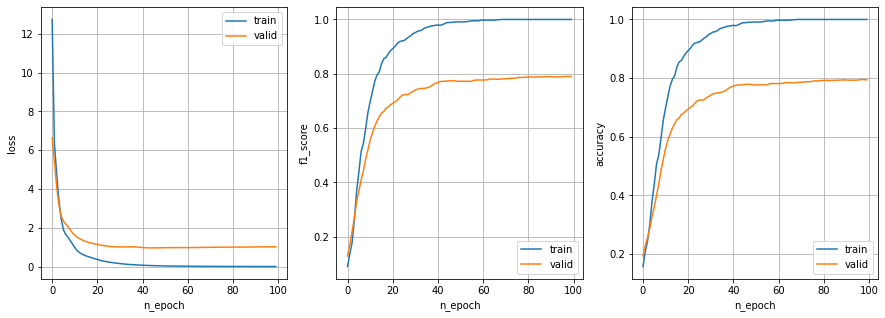

loss: 0.08908771723508835, f1: 0.9827428333329882, acc: 0.9828628897666931


In [33]:
X_test_80 = X_test[0:int(len(X_test)*0.80)] 
Y_test_80 = Y_test[0:int(len(Y_test)*0.80)] 

X_train ,Y_train, X_valid, Y_valid, X_test_80, Y_test_80 = arrays_a_tensores(X_test_80, Y_test_80)

avance_y_grafica(X_test_80, Y_test_80)

# 100% de tamaño de test set

In [36]:
# parametros del modelo
input_dim, output_dim, hidden = 28*28, 10, 50

# modelo 
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, output_dim)
  )

# optimizer y criteria
optimizer = torch.optim.Adam(model.parameters())  
criteria = torch.nn.CrossEntropyLoss()

6000
Epoch [1/100], loss: 15.837153434753418. f1:0.04669018990938513 acc: 0.09316666424274445 
6000
Epoch [2/100], loss: 8.731475830078125. f1:0.1085709307309177 acc: 0.13950000703334808 
6000
Epoch [3/100], loss: 6.105369567871094. f1:0.15714431613034957 acc: 0.20600000023841858 
6000
Epoch [4/100], loss: 4.483317852020264. f1:0.20809748213004725 acc: 0.26350000500679016 
6000
Epoch [5/100], loss: 3.4218029975891113. f1:0.29137290554779804 acc: 0.3401666581630707 
6000
Epoch [6/100], loss: 2.7382352352142334. f1:0.35876630636922213 acc: 0.38449999690055847 
6000
Epoch [7/100], loss: 2.2307896614074707. f1:0.42043757552128574 acc: 0.429500013589859 
6000
Epoch [8/100], loss: 1.9741158485412598. f1:0.4682650110359374 acc: 0.4740000069141388 
6000
Epoch [9/100], loss: 1.7951422929763794. f1:0.5098810710503215 acc: 0.5105000138282776 
6000
Epoch [10/100], loss: 1.5672341585159302. f1:0.5609268166999939 acc: 0.5568333268165588 
6000
Epoch [11/100], loss: 1.3428016901016235. f1:0.6120690775

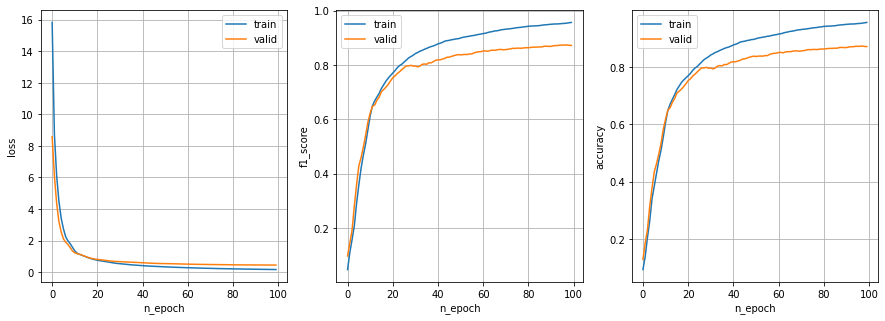

loss: 0.1562214493751526, f1: 0.9566662647178766, acc: 0.9566666483879089


In [37]:
 X_train,Y_train, X_valid, Y_valid, X_test, Y_test = arrays_a_tensores(X_test, Y_test)

avance_y_grafica(X_test, Y_test)

# Analisis parte 2

i) Que varía el tamaño de test set da cambios más significativos que variando el tamaño del training set, ya que se tiene un porcentaje de datos menor, por lo cuál aplicar el modelo entrenado en este test set puede arrojar más errores si se obtiene menor cantidad de datos.

ii y iii) Cuando se modificó el tamaño del test set, fue mas notoria la mejoría del aprendizaje del modelo. Por ejemplo, emepzando con una perdida de 1.6 cuando se tenía el 10% de los datos iniciales del test set, se llegó a 0.15 de pérdida con todos los datos del test set, de igual manera con la accuracy que se empezó con 0.69 y se obtuvo 0.95 con los datos totales del test set, acercandose la gráfica mucho más.